<a href="https://colab.research.google.com/github/limesun/Transfer-Learning/blob/master/Practice_of_lesson4_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [4]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/content/data/movie_lens_sample')

In [5]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [9]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.615366,0.929887,00:00
1,0.842054,0.675423,00:00
2,0.652815,0.674082,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [10]:
url1 = 'https://raw.githubusercontent.com/limesun/Transfer-Learning/master/ml-100k/ml-100k/u.data'

ratings = pd.read_csv(url1, delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])

ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
url2 = 'https://raw.githubusercontent.com/limesun/Transfer-Learning/master/ml-100k/ml-100k/u.item'

movies = pd.read_csv(url2,  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [12]:
len(ratings)

100000

In [13]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [15]:
data.show_batch()

userId,title,target
907,"Frighteners, The (1996)",4.0
717,Mother Night (1996),4.0
109,Candyman (1992),2.0
22,Glory (1989),4.0
405,Spirits of the Dead (Tre passi nel delirio) (1968),1.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


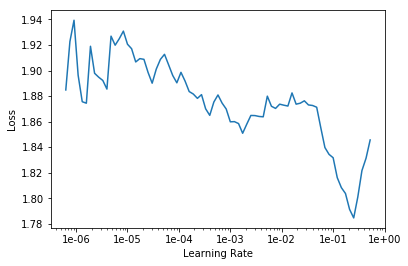

In [18]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [19]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.952641,0.934595,00:10
1,0.878485,0.885962,00:10
2,0.757171,0.838107,00:10
3,0.658690,0.814908,00:10
4,0.573938,0.814658,00:10


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [22]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [23]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [24]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [27]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3678),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3194),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2803), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2587), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2470), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2468), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2411), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2394), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2330), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2264), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2260), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2241),
  'Tales from the Crypt Presents: Bordello of Blood (1996)',
  2.6363636363636362),
 (tensor(-0.2227), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2202), 'Beverly Hills Ninja (1997)'

In [28]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6251), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5974), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5708), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5707), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5485), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5473), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5325), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5103), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5013), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4910), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4890), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4789), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4734), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4625), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4623), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [29]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [30]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [32]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2342), "McHale's Navy (1997)"),
 (tensor(1.2018), 'Home Alone 3 (1997)'),
 (tensor(1.1925), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1808), 'Bio-Dome (1996)'),
 (tensor(1.1675), 'Congo (1995)'),
 (tensor(1.1622), 'Jungle2Jungle (1997)'),
 (tensor(1.1347), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.1268), 'Leave It to Beaver (1997)'),
 (tensor(1.0702), 'Grease 2 (1982)'),
 (tensor(1.0675), 'Free Willy 3: The Rescue (1997)')]

In [33]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0474), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0469), 'Godfather, The (1972)'),
 (tensor(-1.0221), 'Close Shave, A (1995)'),
 (tensor(-0.9883), 'Casablanca (1942)'),
 (tensor(-0.9826), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-0.9754), 'Chinatown (1974)'),
 (tensor(-0.9713), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9603), 'Third Man, The (1949)'),
 (tensor(-0.9449),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9268), 'Apocalypse Now (1979)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [35]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8225), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.8141), 'Keys to Tulsa (1997)'),
 (tensor(0.8074), 'Cable Guy, The (1996)'),
 (tensor(0.8031), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7981), 'Stupids, The (1996)'),
 (tensor(0.7687), 'Trainspotting (1996)'),
 (tensor(0.7679), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7579), 'Brazil (1985)'),
 (tensor(0.7556), 'Sweet Hereafter, The (1997)'),
 (tensor(0.7467), 'Dead Man (1995)')]

In [36]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1141), 'Braveheart (1995)'),
 (tensor(-1.0915), 'Titanic (1997)'),
 (tensor(-1.0636), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9461), 'Independence Day (ID4) (1996)'),
 (tensor(-0.9096), "It's a Wonderful Life (1946)"),
 (tensor(-0.8639), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8639), 'Air Force One (1997)'),
 (tensor(-0.8526), 'American President, The (1995)'),
 (tensor(-0.8525), 'Pretty Woman (1990)'),
 (tensor(-0.8391), 'Hunt for Red October, The (1990)')]

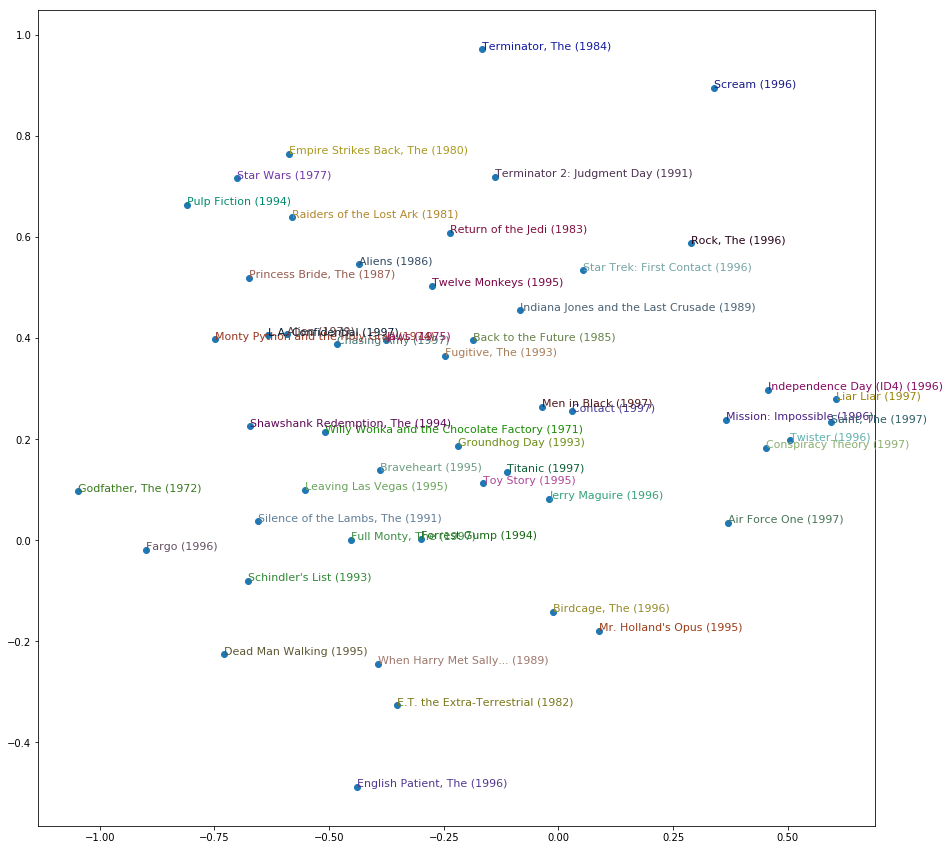

In [37]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()